# Implementing A Logistic Regression Model from Scratch with PyTorch

![alt text](https://drive.google.com/uc?export=view&id=11Bv3uhZtVgRVYVWDl9_ZAYQ0GU36LhM9)  
![alt text](logistic_regression_01.png)


In this tutorial, we are going to implement a logistic regression model(逻辑回归模型) from scratch with PyTorch. The model will be designed with neural networks(神经网络) in mind and will be used for a simple image classification task. I believe this is a great approach to begin understanding the fundamental building blocks behind a neural network. Additionally, we will also look at best practices on how to use PyTorch for training neural networks.

After completing this tutorial the learner is expected to know the basic building blocks of a logistic regression model. The learner is also expected to apply the logistic regression model to a binary image classification problem of their choice using PyTorch code.  

1. 知道逻辑回归的基本模型
2. 在二分类图片分类中使用逻辑回归

---

**Author:** Elvis Saravia ( [Twitter](https://twitter.com/omarsar0) | [LinkedIn](https://www.linkedin.com/in/omarsar/))

**Complete Code Walkthrough:** [Blog post](https://medium.com/dair-ai/implementing-a-logistic-regression-model-from-scratch-with-pytorch-24ea062cd856?source=friends_link&sk=49dcddb17d1d021d2d677f3666c88463)

In [2]:
## Import the usual libraries
import torch            # Torch 是一个经典的对多维矩阵数据进行操作的张量（tensor ）库，在机器学习和其他数学密集型应用有广泛应用。它提供了张量（tensor）操作和计算图构建的功能；提供了自动求导（Autograd）功能，使得用户可以轻松地构建和训练神经网络模型。
import torchvision      # Torchvision 主要用于计算机视觉任务，包括图像处理、数据加载、数据增强、预训练模型等。Torchvision 提供了各种经典的计算机视觉数据集的加载器，以及用于数据预处理和数据增强的工具，可以帮助用户更轻松地进行图像分类、目标检测、图像分割等任务。
import torch.nn as nn   # 导入torch.nn并通过nn来引用  Neural Network:神经网络
# torchvision 主要包含三部分：
# models：      提供深度学习中各种经典网络的网络结构以及预训练好的模型，包括 AlexNet 、VGG 系列、ResNet 系列、Inception 系列等；
# datasets：    提供常用的数据集加载，设计上都是继承 torch.utils.data.Dataset，主要包括 MNIST、CIFAR10/100、ImageNet、COCO等；
# transforms：  提供常用的数据预处理操作，主要包括对 Tensor 以及 PIL Image 对象的操作；
from torchvision import datasets, models, transforms
import os               # python标准库--os模块 Os库提供通用的、基本的操作系统交互功能 常用路径操作、进程管理、环境参数等几类
import numpy as np      # 处理数组和矩阵
import matplotlib.pyplot as plt # 绘图

%matplotlib inline

In [3]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # torch.device代表将torch.Tensor分配到的设备的对象。判断设备是用显卡还是cpu
print (device)

cpu


## Importing Dataset
In this tutorial we will be working on an image classification problem. You can find the public dataset [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip). 

The objective of our model is to learn to classify between "bee" vs. "no bee" images.

Uncomment the code below to download and unzip the data.

In [4]:
# download the data
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip

## Data Transformation
This is an image classification task, which means that we need to perform a few transformations on our dataset before we train our models. I used similar transformations as used in this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial). For a detailed overview of each transformation take a look at the official torchvision [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html).

The following code block performs the following operations:
- The `data_transforms` contains a series of transformations that will be performed on each image found in the dataset. This includes cropping the image, resizing the image, converting it to tensor, reshaping it, and normalizing it. 
- Once those transformations have been defined, then the `DataLoader` function is used to automatically load the datasets and perform any additional configuration such as shuffling, batches, etc.

In [5]:
# t = torch.tensor(np.arange(6).reshape(2, 3))
# print(t)
# print(t.shape)
# t = torch.reshape(t, (-1,))
# print(t)
# print(t.shape)
# t = torch.reshape(t, (6,))
# print(t)
# print(t.shape)
# t = torch.reshape(t, (3,2))
# print(t)
# print(t.shape)

In [6]:
# configure root folder on your gdrive
data_dir = 'hymenoptera_data'       # 配置根文件夹名称

# custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size        # newsize: 数据shape

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)  # 进行维度重组
        return result

# transformations used to standardize and normalize the datasets
data_transforms = {                     # 用于标准化和规范化数据集的转换
    # 训练集
    'train': transforms.Compose([       # 变换对象；这些变换操作通常用于数据预处理，例如图像数据的缩放、裁剪、旋转等。使用transforms.Compose可以将多个数据变换组合在一起，以便将它们应用于数据。
        transforms.Resize(224),         # 调整图像大小（将图片短边缩放至x，长宽比保持不变）
        transforms.CenterCrop(224),     # 从中心开始裁剪（CenterCrop(size)：从图片中心开始沿两边裁剪，裁剪后的图片大小为（size*size）） 244 * 244 = 59536
        transforms.ToTensor(),          # 转化为张量
        ReshapeTransform((-1,))         # flattens the data 将多维的数据转化为一维--(-1代表的是n 当有另一维时 -1的值为总/另一维） n=tensor的长度/第一个参数
    ]),
    # (validation)训练集中的测试集--validation的主要作用是来验证是否过拟合、以及用来调节训练参数等(边训练边看到训练的结果，及时判断学习状态)
    'val': transforms.Compose([
        transforms.Resize(224),     
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))         # flattens the data
    ]),
}

# load the correspoding folders         加载数据集相关文件夹
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),        # 路径 ../hymenoptera_data/train ; os.path.join()函数用于路径拼接文件路径，可以传入多个路径
                                          data_transforms[x])               # 对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片
                  for x in ['train', 'val']}                                # 分别遍历训练集和验证集

# load the entire dataset; we are not using minibatches here
# Mini-batching 是一个一次训练数据集的一小部分，而不是整个训练集的技术。它可以使内存较小、不能同时训练整个数据集的电脑也可以训练模型。
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],                    # 创建一个DataLoader对象 传入数据集为上述训练数据集
                                            batch_size=len(image_datasets['train']),    # 每个batch的样本数为训练集样本的大小
                                            shuffle=True)                               # 数据会被随机打乱

test_dataset = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=len(image_datasets['val']),
                                           shuffle=True)

In [7]:
len(image_datasets['train']), len(image_datasets['val'])    # 打印训练集 训练集中的测试集数据大小

(244, 153)

## Print sample
It's always a good practise to take a quick look at the dataset before training your models. Below we print out an example of one of the images from the `train_dataset`.

dim:  150528
Dimension of image: torch.Size([244, 150528]) 
 Dimension of labels torch.Size([244])


C:\Users\25627\AppData\Local\Temp\ipykernel_24116\3977878491.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())    # 将数据还原并打印图片


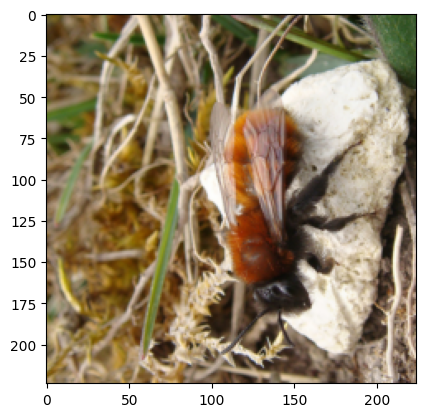

In [8]:
# print("train_dataset: ", train_dataset)

# load the entire dataset
# next()函数用于获取迭代器的下一个元素。在PyTorch的DataLoader中，可以使用next()函数获取下一个批次的数据。 iter()函数用于将可迭代对象转换为迭代器
x, y = next(iter(train_dataset))   # 将train_dataset转化为迭代器并迭代取出第一批次的数据
# print("x: ", x)
# print("y: ", y)
# print(y.size()[1])

# print one example
dim = x.shape[1]        # 维度
print("dim: ", dim)
print("Dimension of image:", x.shape, "\n",     # Dimension of image: torch.Size([244, 150528])   (bees)121 + (ants)123 = 244张图片，即输入数据     244 * 244 = 59536
      "Dimension of labels", y.shape)           # Dimension of labels torch.Size([244])

# squeeze() 从数组的形状中删除单维度条目，即把shape中为1的维度去掉
plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())    # 将数据还原并打印图片

## Building the Model
Let's now implement our [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model. Logistic regression is one in a family of machine learning techniques that are used to train binary classifiers. They are also a great way to understand the fundamental building blocks of neural networks, thus they can also be considered the simplest of neural networks where the model performs a `forward` and `backward` propagation to train the model on the data provided. 

If you don't fully understand the structure of the code below, I strongly recommend you to read the following [tutorial](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c), which I wrote for PyTorch beginners. You can also check out [Week 2](https://www.coursera.org/learn/neural-networks-deep-learning/home/week/2) of Andrew Ng's Deep Learning Specialization course for all the explanation, intuitions, and details of the different parts of the neural network such as the `forward`, `sigmoid`, `backward`, and `optimization` steps. 

In short:
- The `__init__` function initializes all the parameters (`W`, `b`, `grad`) that will be used to train the model through backpropagation. 
- The goal is to learn the `W` and `b` that minimimizes the cost function which is computed as seen in the `loss` function below.

Note that this is a very detailed implementation of a logistic regression model so I had to explicitly move a lot of the computations into the GPU for faster calcuation, `to(device)` takes care of this in PyTorch. 

In [10]:
class LR(nn.Module):    # logistic regression 继承自 nn.module
    def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
        super(LR, self).__init__()  # 将父类的__init__()放置到自己的__init__()中
        # intialize parameters      
        self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)              # 参数 w 权重矩阵；并将此tensor变量copy一份到设备上
        self.b = torch.scalar_tensor(0).to(device)                              # 参数 b 偏置项
        self.grads = {"dw": torch.zeros(dim, 1, dtype=torch.float).to(device),  # 初始化对w的梯度（导数） # dim = x.shape[1]
                      "db": torch.scalar_tensor(0).to(device)}                  # 初始化对b的导数
        self.lr = lr.to(device)                                                 # 学习率

    def forward(self, x):   # 前向传播
        # compute forward
        z = torch.mm(self.w.T, x) + self.b      # 公式 y = w * x + b
        a = self.sigmoid(z)                     # 经过激活函数处理得到前向传播的激活值
        return a    # 预测值

    def sigmoid(self, z):   # sigmoid函数 激活函数
        # compute sigmoid
        return 1/(1 + torch.exp(-z))    # 计算激活函数 g(z)= 1/(1+e^−z)
        
    def backward(self, x, yhat, y):     # 反向传播
        # compute backward
        # https://blog.csdn.net/weixin_44750512/article/details/128947776
        # https://blog.csdn.net/buchidanhuang/article/details/83958947
        # z = w * x + b
        # a = sigmod(z) = 1 / ( 1 + e ^ -x )
        # l = -ylog(a)-(1-y)log(1-a)    交叉熵损失（对数损失函数）
        # grad(L)=(dw,db) 链式求导法则
        self.grads["dw"] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)       # 计算 损失函数 w 的梯度
        self.grads["db"] = (1/x.shape[1]) * torch.sum(yhat - y)             # 计算 损失函数 b 的梯度
    
    def optimize(self):                 # 优化器
        # optimization step
        self.w = self.w - self.lr * self.grads["dw"]    # 更新参数w
        self.b = self.b - self.lr * self.grads["db"]    # 更新参数b

## utility functions
def loss(yhat, y):              # 计算损失
    m = y.size()[1]             # 标记数
    return -(1/m)* torch.sum(y*torch.log(yhat) + (1 - y)* torch.log(1-yhat))   # 交叉熵损失（对数损失函数）

def predict(yhat, y):           # 预测类别并返回准确率
    y_prediction = torch.zeros(1, y.size()[1])  # 初始化一个值为0的1*255的张量
    for i in range(yhat.size()[1]):     # 迭代逻辑回归计算值
        if yhat[0, i] <= 0.5:           # 如果结果 <= 0.5
            y_prediction[0, i] = 0      # 归入0
        else:                           # 如果结果 》 0.5
            y_prediction[0, i] = 1      # 归入1
    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100  # 计算准确率 结果*100显示

## Pretesting the Model
It is also good practice to test your model and make sure the right steps are taking place before training the entire model.

In [11]:
# model pretesting
x, y = next(iter(train_dataset))    # 取训练数据 x特征数据 y标记

# flatten/transform the data
x_flatten = x.T     # 对特征张量进行转置 x.shape:torch.Size([244, 150528])  x_flatten.shape:torch.Size([150528, 244])
y = y.unsqueeze(0)  # unsqueeze()函数起升维的作用,参数表示在哪个地方加一个维度。0表示在张量最外层加一个中括号变成第一维。

# num_px is the dimension of the images
dim = x_flatten.shape[0]   # 特征数

# model instance
model = LR(dim)         # 实例化逻辑回归分类
model.to(device)        # 将model复制到指定运行设备中
yhat = model.forward(x_flatten.to(device))      # 前向传播
yhat = yhat.data.cpu()      # 将数据的处理设备从其他设备（如.cuda()拿到cpu上），不会改变变量类型，转换后仍然是Tensor变量。                      
 
# calculate loss
cost = loss(yhat, y)                # 计算损失
prediction = predict(yhat, y)       # 预测分类并返回准确率
print("Cost: ", cost)               # 打印损失值
print("Accuracy: ", prediction)     # 打印准确率

# backpropagate
model.backward(x_flatten.to(device), yhat.to(device), y.to(device)) # 反向传播
model.optimize()    # 更新参数w和b

Cost:  tensor(0.6931)
Accuracy:  tensor(50.4098)


## Train the Model
It's now time to train the model. 

In [14]:
# hyperparams
costs = []                  # 损失矩阵，保存迭代的损失值
dim = x_flatten.shape[0]    # 维度，即特征数
learning_rate = torch.scalar_tensor(0.0001).to(device)  # 学习率
num_iterations = 500        # 迭代次数
lrmodel = LR(dim, learning_rate)    # 实例化逻辑回归
lrmodel.to(device)          # 将模型布置到对应数据中

# transform the data
def transform_data(x, y):   # 转换数据
    x_flatten = x.T         # 对特征张量进行转置 x.shape:torch.Size([244, 150528])  x_flatten.shape:torch.Size([150528, 244])
    y = y.unsqueeze(0)      # # unsqueeze()函数起升维的作用,参数表示在哪个地方加一个维度。0表示在张量最外层加一个中括号变成第一维。
    return x_flatten, y 

# train the model
for i in range(num_iterations):                 # 迭代训练
    x, y = next(iter(train_dataset))            # 取训练数据 x特征数据 y标记
    test_x, test_y = next(iter(test_dataset))   # 取训练集中的测试集 test_x特征数据, test_y标记
    x, y = transform_data(x, y)                 # 转换训练数据
    test_x, test_y = transform_data(test_x, test_y) # 转换测试数据

    # forward
    yhat = lrmodel.forward(x.to(device))        # 前向传播得到预测值
    cost = loss(yhat.data.cpu(), y)             # 计算损失
    train_pred = predict(yhat, y)               # 预测分类并返回准确率
        
    # backward
    lrmodel.backward(x.to(device), yhat.to(device), y.to(device))   # 反向传播
    lrmodel.optimize()      # 优化参数

    # test
    yhat_test = lrmodel.forward(test_x.to(device))  # 对测试数据计算预测值
    test_pred = predict(yhat_test, test_y)          # 预测分类并返回准确率

    if i % 10 == 0:         # 每10轮
        costs.append(cost)  # 保存损失值

    if i % 10 == 0:         # 每10轮
        print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i,                    # 轮次
                                                                                    cost,               # 损失值
                                                                                    train_pred,         # 训练集准确率
                                                                                    test_pred))         # 验证集准确率

Cost after iteration 0: 0.6931472420692444 | Train Acc: 50.40983581542969 | Test Acc: 45.75163269042969


KeyboardInterrupt: 

## Result
From the loss curve below you can see that the model is sort of learning to classify the images given the decreas in the loss. I only ran the model for `100` iterations. Train the model for many more rounds and analyze the results. In fact, I have suggested a couple of experiments and exercises at the end of the tutorial that you can try to get a more improved model.

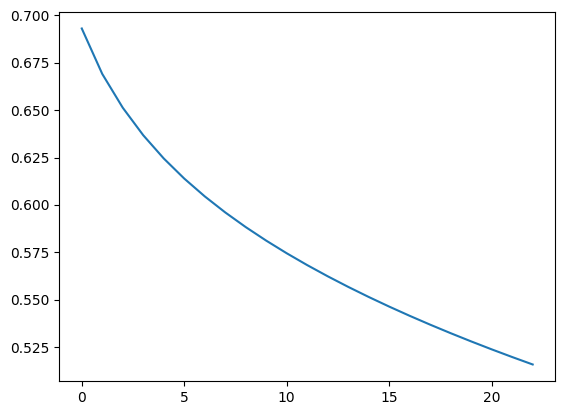

In [13]:
## the trend in the context of loss
plt.plot(costs) # 绘制损失值曲线
plt.show()      # 显示图形

## Some Notes
There are many improvements and different experiments that you can perform on top of this notebook to keep practising ML:
- It is always good to normalize/standardize your images which helps with learning. As an experiment, you can research and try different ways to standarize the dataset. We have normalized the dataset with the builtin PyTorch [normalizer](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) which uses the mean and standard deviation. Play around with different transformations or normalization techniques. What effect does this have on learning in terms of speed and loss?
- You can try many things to help with learning such as playing around with the learning rate. Try to decrease and increase the learning rate and observe the effect of this in learning? 
- If you explored the dataset further, you may have noticed that all the "no-bee" images are actually "ant" images. If you would like to create a more robust model, you may want to make your "no-bee" images more random and diverse through some data augmentation technique. This is a more advanced approach but there is a lot of good content to try out this idea. 
- The model is not really performing well just using simple logistic regression model. It could be because of the dataset I am using and because I didn't train it for long enough. Hyperparameters may also be off. It is a relatively small dataset but the performance could get better with more data and training over time. A more challenging task involves adopting the model to other datasets. Give it a try!
- Another important part that is missing in this tutorial is the comprehensive analysis of the model results. If you understand the code, it should be easy to figure out how to test with a few examples. In fact, it would also be great if you can put aside a small testing dataset for this part of the exercise, so as to test the generalization capabilities of the model.
- We built the logistic regression model from scratch but with libraries like PyTorch, these days you can simply leverage the high-level functions that implement certain parts of the neural network for you. This simplifies your code and minimizes the amount of bugs in your code. Plus you don't have to code your neural networks from scratch all the time. As a bonus exercise, try to adapt PyTorch builtin modules and functions for implementing a simpler, more concise version of the above logistic regression model. I will also add this as a to-do task for myself and post a solution soon. 

## References
- [Understanding the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
- [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial)
- [Deep Learning Specialization by Andrew Ng](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome)